### Explore sensitivity to varying soil moisture, growth-limiting factor, etc.

In [7]:
run "/Users/octavia/Dropbox/fire/fire_model/startup.py"

In [8]:
params = default_params()
params.update({ "severity" : 0.7})
p = RCSR(params)


### How does biomass change with decreasing soil moisture?

Text(0, 0.5, '$\\hat G_l$')

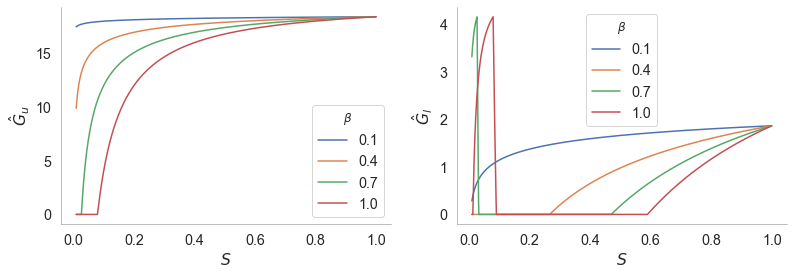

In [9]:
fig, axes = plt.subplots(1, 2, figsize = (13, 4))

S = np.arange(0.01, 1, .001)

for beta in np.arange(0.1, 1.1, 0.3):
    beta = np.round(beta, 1)
    
    ax = axes[0]    
    G_u_mean = mean_G_u(p.r_u ,  p.k_u , S, 
                        beta , p.RI , p.severity)
    ax.plot(S, G_u_mean, label = beta)
    
    ax = axes[1]
    
    G_l_mean = mean_G_l(p.r_l, p.r_u, p.k_l, p.k_u, S, 
                        beta, p.alpha , p.RI , p.severity )

    ax.plot(S, G_l_mean, label = beta)

axes[0].legend(title =r"$\beta$")
axes[1].legend(title =r"$\beta$")
axes[0].set_xlabel("$S$")
axes[1].set_xlabel("$S$")
axes[0].set_ylabel("$\hat G_u$")
axes[1].set_ylabel("$\hat G_l$")


Suppose that increasing soil moisture *decreases* the probability of ignition as 
$$  p = \frac{1}{RI}(1-S)$$

The new 'effective' RI would be $1/p$:
$$RI' = \frac{RI}{(1-S)}$$

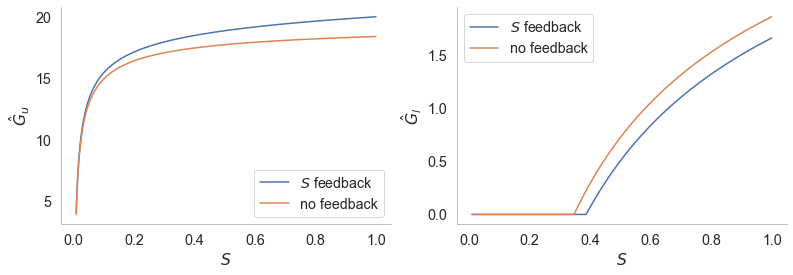

In [10]:
fig, axes = plt.subplots(1, 2, figsize = (13, 4))

S = np.arange(0.01, 1, .001)
RI = p.RI/(1-S)

beta = np.round(p.beta, 1)

ax = axes[0]    
G_u_mean = mean_G_u(p.r_u ,  p.k_u , S, beta , RI , p.severity)
ax.plot(S, G_u_mean, label = "$S$ feedback")

G_u_mean = mean_G_u(p.r_u ,  p.k_u , S, beta , p.RI , p.severity)
ax.plot(S, G_u_mean, label = "no feedback")
ax = axes[1]


G_l_mean = mean_G_l(p.r_l, p.r_u, p.k_l, p.k_u, S, 
                    beta, p.alpha , RI , p.severity )

ax.plot(S, G_l_mean,label = "$S$ feedback")
G_l_mean = mean_G_l(p.r_l, p.r_u, p.k_l, p.k_u, S, 
                    beta, p.alpha , p.RI , p.severity )
ax.plot(S, G_l_mean,label = "no feedback")

axes[0].legend()
axes[1].legend()
axes[0].set_xlabel("$S$")
axes[1].set_xlabel("$S$")
axes[0].set_ylabel("$\hat G_u$")
axes[1].set_ylabel("$\hat G_l$")
fig.savefig(fig_dir + '/stability.png', format='png', dpi=1000, bbox_inches = "tight")

### Check analytical expression $\partial G_l / \partial S$

In [11]:
def S_loc_G_l_min(r_u,  k_u, S, beta, alpha, RI, severity):
    """
    Find the soil moisture content where the lower canopy has a minimum value
    """
    Z = np.log(1-severity)/RI
    S_min = -2*Z*alpha*k_u/(alpha*k_u*r_u - r_u*Z)**(1/beta) 
    return S_min


In [12]:
def dG_u_dS( r,  k, S, beta, RI, severity):
    """
    Partial derivative of G_u with respect to S
    Also applies for G_l when G_u = 0 
    """
    return - beta*k*S**(-1. -beta)*np.log(1-severity)/RI/r
    

In [13]:
def dG_l_dS(r_l, r_u, k_l,  k_u, S, beta, alpha, RI, severity):
    
    Z = np.log(1-severity)/RI
    
    a = beta*k_l*S**(-1 - 2*beta)/(r_l*r_u)
    b = r_u*S**beta*(alpha*k_u- Z) + 2*alpha*k_u*Z
    
    return a*b


In [14]:
params = default_params()
params.update({ "severity" : 0.5, "beta" : 0.5, "RI" : 10})
p = RCSR(params)


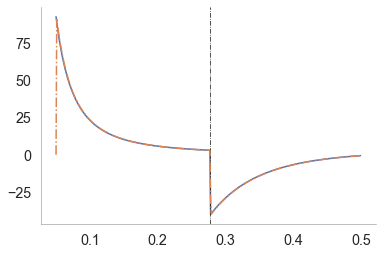

In [15]:
Ss = np.arange(0.05, 0.5, .001)

for beta in [1]:
    
    # soil moisture for which G_u goes to 0
    S_G_u_lim = (-np.log(1-p.severity)/p.RI/p.r_u)**(1/beta)
    
    # soil moisture location of the minimum G_l
    S_G_l_min = S_loc_G_l_min(p.r_u,  p.k_u, Ss, beta, p.alpha, p.RI, p.severity)

    # compute the lower canopy derivative
    deriv = dG_l_dS(p.r_l, p.r_u, p.k_l,  p.k_u, Ss, beta, p.alpha, p.RI, p.severity)
    deriv_no_G_u = dG_u_dS( p.r_l,  p.k_l, Ss, beta, p.RI, p.severity)
    deriv[Ss <= S_G_u_lim] = deriv_no_G_u[Ss <= S_G_u_lim]

    plt.plot(Ss, deriv, label = beta, ls =  '-')
    
    plt.axvline(S_G_u_lim, c = "k", ls = "-.", lw = 0.75 )

    # mean G_l
    G_l_mean =   mean_G_l(p.r_l, p.r_u, p.k_l, p.k_u, Ss , beta, p.alpha , p.RI , p.severity )

    # numerical
    deriv_num = np.diff(G_l_mean)/np.diff(Ss)[0]
    deriv_num =  np.insert(deriv_num,0,0)
    plt.plot(Ss,deriv_num, label = beta, ls =  "-.")
    

